In [38]:
import torch
from skimage import io
import skimage.color
import numpy as np
from model.unet import UNet
import matplotlib.pyplot as plt

device = torch.device('cuda')

def load_bw_image(path):
    original = io.imread(path)
    L_channel = (original[:, :, 0] - 128) / 128
    L_channel = np.expand_dims(L_channel, axis=[0, 1]).astype(np.float32)
    return L_channel

def load_color_image(path):
    original = io.imread(path)
    image = skimage.color.rgb2lab(original)
    L_channel = (image[:, :, 0] - 50) / 50
    L_channel = np.expand_dims(L_channel, axis=[0, 1]).astype(np.float32)
    return original, L_channel

In [61]:
model_path = '/home/vltava/shanghai/checkpoint/lr0.0001_2020-05-12-18-47-50/epoch79.pkl'
model = torch.nn.DataParallel(UNet().to(device))

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_weights'])

<All keys matched successfully>

In [62]:
image_path = '/home/vltava/tiny-dataset/train/966.png'
original_image, L_channel = load_color_image(image_path)
print(f'Image shape: {original_image.shape}')
print(f'L channel shape: {L_channel.shape}')

output = model(torch.tensor(L_channel).to(device))
print(f'Predictions shape: {output.shape}')

Image shape: (360, 480, 3)
L channel shape: (1, 1, 360, 480)
Predictions shape: torch.Size([1, 2, 360, 480])


Lab shape: (360, 480, 3)
Mean in L channel: 49.797171536063104
Mean in a channel: 4.2803587946682065
Mean in b channel: -2.2565028151324777


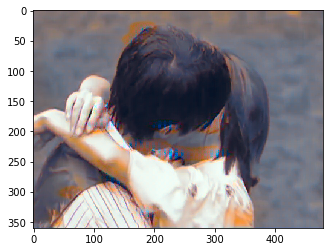

In [63]:
ab_channels = output.squeeze().cpu().detach().numpy()
Lab = np.concatenate([L_channel[0], ab_channels], axis=0)
Lab = Lab.transpose((1, 2, 0))
print(f'Lab shape: {Lab.shape}')

Lab = (Lab * [50, 128, 128] + [50, 0, 0])
print(f'Mean in L channel: {Lab[:, :, 0].mean()}')
print(f'Mean in a channel: {Lab[:, :, 1].mean()}')
print(f'Mean in b channel: {Lab[:, :, 2].mean()}')

rgb_output = skimage.color.lab2rgb(Lab)

plt.imshow(rgb_output)
